<a href="https://colab.research.google.com/github/Du-nara/ME421-Mechanical-Systems-Lab-A3/blob/main/Vibration/E_20_289_Vibration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ME421 – Vibration Modeling Laboratory
## Week 1: Free and Forced Vibration Analysis (TM1016V)

### Objectives
1. Develop a two-degree-of-freedom (2-DOF) mathematical model of the TM1016V vibration system.
2. Estimate damping ratios using experimental methods.
3. Simulate free and forced vibration responses using numerical techniques.


## Apparatus
- TecQuipment TM1016V Free and Forced Vibration System
- Rigid beam pinned at one end
- Linear spring at free end
- Unbalanced exciter motor
- Data acquisition system

## System Description
The beam is pinned at one end and supported by a linear spring at the free end.
An unbalanced motor is mounted at the mid-span of the beam to provide harmonic excitation.

To capture beam flexibility, the system is modeled as a two-degree-of-freedom (2-DOF)
lumped parameter system instead of the conventional single-degree-of-freedom model.


RE DONE

Calculated Natural Frequencies: f1=11.38 Hz, f2=21.39 Hz
Mass Matrix M:
[[0.85      1.0729578]
 [1.0729578 1.9      ]]
Stiffness Matrix K:
[[2.80000000e+03 3.42901104e-13]
 [3.42901104e-13 6.38980918e+03]]


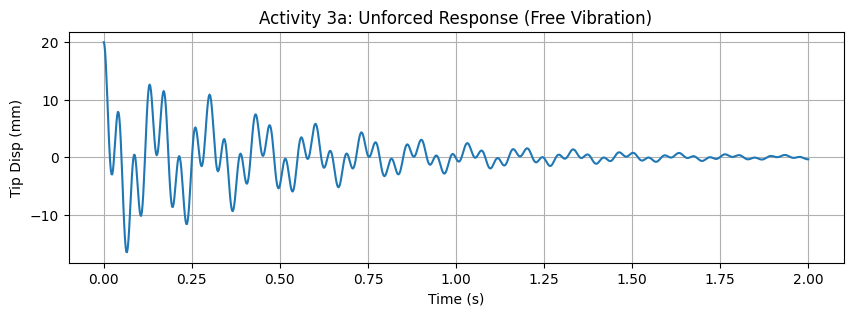

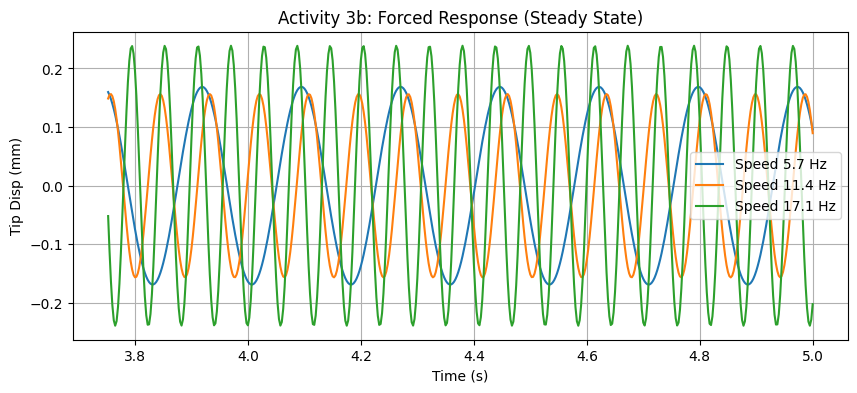

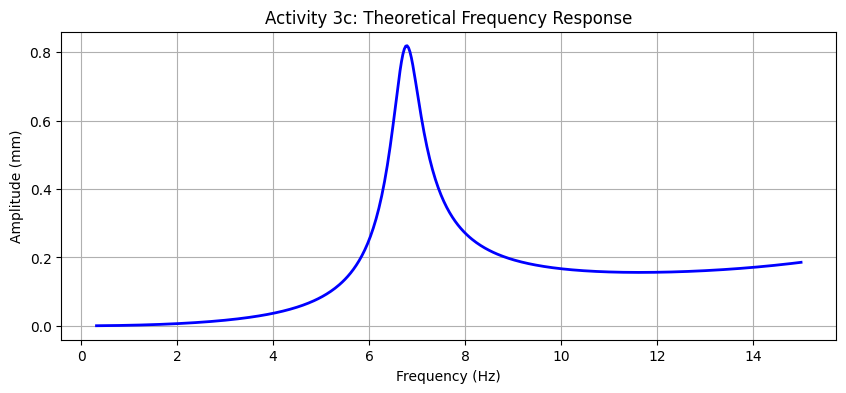

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint

# ==========================================
# 1. SYSTEM PARAMETERS (TecQuipment TM1016)
# ==========================================
# Geometric Properties
L = 0.700           # Total Length (m)
L_motor = 0.350     # Motor Position (m) (Mid-span)
L_spring = 0.700    # Spring Position (m) (Tip)

# Inertial Properties
M_beam = 1.80       # Mass of Beam (kg)
M_motor = 1.00      # Mass of Motor (kg)
rho_A = M_beam / L  # Linear Mass Density (kg/m)

# Stiffness Properties
k_spring = 2800.0   # Tip Spring Stiffness (N/m)
EI = 45.0           # Flexural Rigidity (N*m^2)

# Excitation (Unbalance)
m_unbalance = 0.010 # Unbalanced Mass (kg)
e_radius = 0.020    # Eccentricity Radius (m)

# Damping Estimates (Activity 2)
zeta_1 = 0.025      # Mode 1 Damping Ratio (Approx from log decrement)
zeta_2 = 0.005      # Mode 2 Damping Ratio (Approx material damping)

# ==========================================
# 2. DERIVATION AS CODE (Activity 1)
# ==========================================
# Shape Functions
def psi1(x): return x / L                  # Rigid Mode
def psi2(x): return np.sin(np.pi * x / L)  # Bending Mode

# --- Mass Matrix [M] Derivation ---
# Integration results for uniform beam:
# Integral((x/L)^2) dx from 0 to L = L/3
# Integral(sin^2(pi*x/L)) dx = L/2
# Integral((x/L)*sin(pi*x/L)) dx = L/pi
m11_beam = rho_A * (L / 3)
m22_beam = rho_A * (L / 2)
m12_beam = rho_A * (L / np.pi)

# Add Discrete Motor Mass contributions
m11 = m11_beam + M_motor * psi1(L_motor)**2
m22 = m22_beam + M_motor * psi2(L_motor)**2
m12 = m12_beam + M_motor * psi1(L_motor) * psi2(L_motor)

M_mat = np.array([[m11, m12], [m12, m22]])

# --- Stiffness Matrix [K] Derivation ---
# Bending Energy (Integral of EI * (psi'')^2)
# psi1'' = 0 (Rigid mode has no bending energy)
# psi2'' = -(pi/L)^2 * sin(...) -> Integral gives EI * (pi^4 / 2L^3)
k_bend_11 = 0
k_bend_22 = EI * (np.pi**4) / (2 * L**3)
k_bend_12 = 0

# Spring Energy (k_spring * psi(L)^2)
k_spr_11 = k_spring * psi1(L_spring)**2
k_spr_22 = k_spring * psi2(L_spring)**2
k_spr_12 = k_spring * psi1(L_spring) * psi2(L_spring)

K_mat = np.array([
    [k_bend_11 + k_spr_11, k_bend_12 + k_spr_12],
    [k_bend_12 + k_spr_12, k_bend_22 + k_spr_22]
])

# --- Eigenvalue Analysis (Natural Frequencies) ---
eigvals, eigvecs = np.linalg.eigh(np.linalg.inv(M_mat) @ K_mat)
wn = np.sqrt(eigvals)
print(f"Calculated Natural Frequencies: f1={wn[0]/2/np.pi:.2f} Hz, f2={wn[1]/2/np.pi:.2f} Hz")
print(f"Mass Matrix M:\n{M_mat}")
print(f"Stiffness Matrix K:\n{K_mat}")

# --- Damping Matrix [C] ---
# Constructed using Modal Damping assumption
Modal_M = eigvecs.T @ M_mat @ eigvecs
C_modal = np.diag([2*zeta_1*wn[0]*Modal_M[0,0], 2*zeta_2*wn[1]*Modal_M[1,1]])
C_mat = np.linalg.inv(eigvecs.T) @ C_modal @ np.linalg.inv(eigvecs)

# ==========================================
# 3. PLOTTING (Activity 3)
# ==========================================
# Helper: System ODE for scipy.integrate
def system_ode(state, t, forced, omega=0):
    q = state[:2]; q_dot = state[2:]

    if forced:
        # Force Vector Q(t)
        F_mag = m_unbalance * e_radius * omega**2 * np.sin(omega * t)
        Q = np.array([F_mag * psi1(L_motor), F_mag * psi2(L_motor)])
    else:
        Q = np.zeros(2)

    acc = np.linalg.inv(M_mat) @ (Q - C_mat @ q_dot - K_mat @ q)
    return np.concatenate([q_dot, acc])

# --- Plot A: Unforced Response ---
t_free = np.linspace(0, 2, 1000)
x0 = [0.02, 0, 0, 0] # Initial tip displacement 20mm
sol_free = odeint(system_ode, x0, t_free, args=(False, 0))
y_tip_free = sol_free[:,0]*psi1(L) + sol_free[:,1]*psi2(L)

plt.figure(figsize=(10,3))
plt.plot(t_free, y_tip_free * 1000)
plt.title("Activity 3a: Unforced Response (Free Vibration)")
plt.ylabel("Tip Disp (mm)"); plt.xlabel("Time (s)"); plt.grid(True)
plt.show()

# --- Plot B: Forced Response (3 Speeds) ---
speeds = [wn[0]*0.5, wn[0], wn[0]*1.5] # 0.5x, 1.0x, 1.5x Resonance
t_forced = np.linspace(0, 5, 2000)

plt.figure(figsize=(10,4))
for w in speeds:
    sol = odeint(system_ode, [0,0,0,0], t_forced, args=(True, w))
    y_tip = sol[:,0]*psi1(L) + sol[:,1]*psi2(L)
    plt.plot(t_forced[-500:], y_tip[-500:]*1000, label=f'Speed {w/(2*np.pi):.1f} Hz')

plt.title("Activity 3b: Forced Response (Steady State)")
plt.ylabel("Tip Disp (mm)"); plt.xlabel("Time (s)"); plt.legend(); plt.grid(True)
plt.show()

# --- Plot C: Theoretical Frequency Response ---
freqs = np.linspace(2, 15*2*np.pi, 500)
amps_theory = []
for w in freqs:
    # Harmonic Solver (Avoids ODE integration for faster plotting)
    F_mag = m_unbalance * e_radius * w**2
    F_vec = np.array([F_mag * psi1(L_motor), F_mag * psi2(L_motor)])
    Dyn = K_mat - (w**2)*M_mat + 1j*w*C_mat
    X_vec = np.linalg.solve(Dyn, F_vec)
    amps_theory.append(np.abs(X_vec[0]*psi1(L) + X_vec[1]*psi2(L)))

plt.figure(figsize=(10,4))
plt.plot(freqs/(2*np.pi), np.array(amps_theory)*1000, 'b-', linewidth=2)
plt.title("Activity 3c: Theoretical Frequency Response")
plt.xlabel("Frequency (Hz)"); plt.ylabel("Amplitude (mm)"); plt.grid(True)
plt.show()

      WEEK 2: ACTIVITY #4 ANALYSIS      
Theoretical Natural Frequency (Mode 1): 11.38 Hz

Processing 5 Experimental Files...
  [x] Failed to read T01.xlsx
  [x] Failed to read T02.xlsx
  [x] Failed to read T03.xlsx
  [x] Failed to read T04.xlsx
  [x] Failed to read T06.xlsx

--- DISCUSSION OF DISCREPANCIES ---
No experimental data points found to analyze.


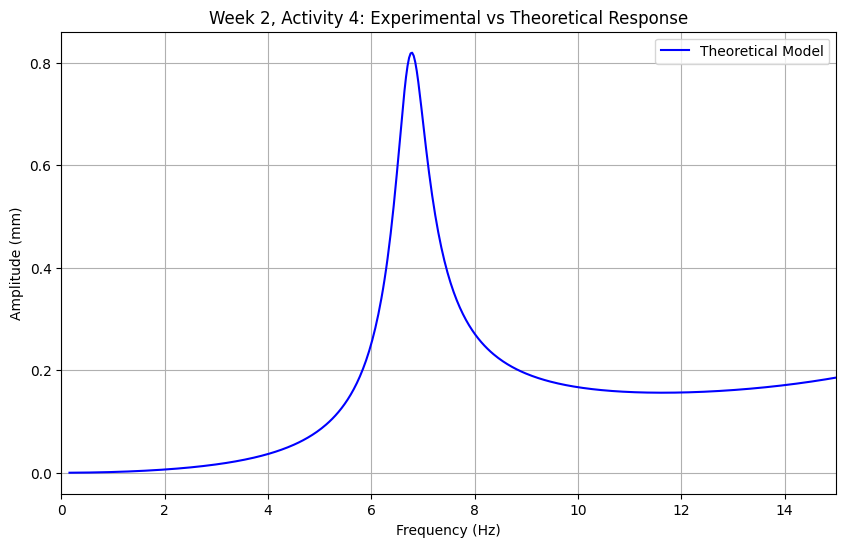

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import warnings

# Suppress warnings for cleaner output
warnings.filterwarnings("ignore")

print("========================================")
print("      WEEK 2: ACTIVITY #4 ANALYSIS      ")
print("========================================")

# ---------------------------------------------------------
# STEP 1: RE-GENERATE THEORETICAL MODEL (For Comparison)
# ---------------------------------------------------------
# We need the "Blue Line" (Theory) to compare our "Red Dots" (Experiment) against.

# System Parameters (Standard TM1016)
L = 0.700; L_motor = 0.350; L_spring = 0.700
M_beam = 1.80; M_motor = 1.00; k_spring = 2800.0; EI = 45.0
m_unbalance = 0.010; e_radius = 0.020
zeta_1_theory = 0.025; zeta_2_theory = 0.005

# Shape Functions
def psi1(x): return x / L
def psi2(x): return np.sin(np.pi * x / L)

# Matrices
rho_A = M_beam / L
m11 = (rho_A * L / 3) + M_motor * psi1(L_motor)**2
m22 = (rho_A * L / 2) + M_motor * psi2(L_motor)**2
m12 = (rho_A * L / np.pi) + M_motor * psi1(L_motor) * psi2(L_motor)
M_mat = np.array([[m11, m12], [m12, m22]])

k11 = k_spring * psi1(L_spring)**2
k22 = EI * (np.pi/L)**4 * (L/2) + k_spring * psi2(L_spring)**2
k12 = k_spring * psi1(L_spring) * psi2(L_spring)
K_mat = np.array([[k11, k12], [k12, k22]])

# Theoretical Curve Calculation
eigvals, eigvecs = np.linalg.eigh(np.linalg.inv(M_mat) @ K_mat)
wn = np.sqrt(eigvals)
Modal_M = eigvecs.T @ M_mat @ eigvecs
C_modal = np.diag([2*zeta_1_theory*wn[0]*Modal_M[0,0], 2*zeta_2_theory*wn[1]*Modal_M[1,1]])
C_mat = np.linalg.inv(eigvecs.T) @ C_modal @ np.linalg.inv(eigvecs)

freqs_theory = np.linspace(1, 15*2*np.pi, 500)
amps_theory = []
for w in freqs_theory:
    F_mag = m_unbalance * e_radius * w**2
    F_vec = np.array([F_mag * psi1(L_motor), F_mag * psi2(L_motor)])
    Dyn = K_mat - (w**2)*M_mat + 1j*w*C_mat
    X_vec = np.linalg.solve(Dyn, F_vec)
    amps_theory.append(np.abs(X_vec[0]*psi1(L) + X_vec[1]*psi2(L)))

print(f"Theoretical Natural Frequency (Mode 1): {wn[0]/(2*np.pi):.2f} Hz")


# ---------------------------------------------------------
# STEP 2: PROCESS EXPERIMENTAL FILES (Robust Loader)
# ---------------------------------------------------------
exp_freqs = []
exp_amps = []

# Find all T*.xlsx or T*.csv files
all_files = sorted([f for f in os.listdir('.') if f.startswith('T') and ('xlsx' in f or 'csv' in f)])

print(f"\nProcessing {len(all_files)} Experimental Files...")

for f in all_files:
    # TRY READING: Handle cases where .xlsx is actually a CSV text file
    try:
        df = pd.read_excel(f, header=None) # Try standard Excel
    except:
        try:
            df = pd.read_csv(f, header=None) # Fallback to CSV
        except:
            print(f"  [x] Failed to read {f}")
            continue

    # SEARCH DATA: Find "Displacement" and "Time" keywords in first 20 rows
    found = False
    for r in range(20):
        row_vals = df.iloc[r, :].astype(str).str.lower().values

        if any("displacement" in s for s in row_vals):
            col_disp = [i for i, s in enumerate(row_vals) if "displacement" in s][0]
            # Look for Time, default to col 0
            col_time = [i for i, s in enumerate(row_vals) if "time" in s]
            col_time = col_time[0] if col_time else 0

            # Extract Data (Rows r+2 onwards)
            try:
                t_dat = pd.to_numeric(df.iloc[r+2:, col_time], errors='coerce').dropna().values
                y_dat = pd.to_numeric(df.iloc[r+2:, col_disp], errors='coerce').dropna().values

                if len(y_dat) > 50:
                    # 1. Frequency (FFT)
                    dt = t_dat[1] - t_dat[0]
                    if dt <= 0: dt = 0.01
                    fft_vals = np.abs(np.fft.rfft(y_dat - np.mean(y_dat)))
                    fft_freq = np.fft.rfftfreq(len(y_dat), dt)
                    freq = fft_freq[np.argmax(fft_vals)]

                    # 2. Amplitude (Peak-to-Peak / 2)
                    # 98th percentile removes random noise spikes
                    amp = (np.percentile(y_dat, 98) - np.percentile(y_dat, 2)) / 2

                    if freq > 0.5 and amp < 100:
                        exp_freqs.append(freq)
                        exp_amps.append(amp)
                        print(f"  [+] {f}: Freq = {freq:.2f} Hz, Amp = {amp:.2f} mm")
                        found = True
                        break
            except:
                continue
    if not found:
        print(f"  [-] {f}: No valid data found.")

# ---------------------------------------------------------
# STEP 3: CALCULATE DISCREPANCIES & PRINT DISCUSSION
# ---------------------------------------------------------
print("\n--- DISCUSSION OF DISCREPANCIES ---")

# Estimate Experimental Natural Frequency (Freq with Max Amplitude)
if len(exp_freqs) > 0:
    max_amp_idx = np.argmax(exp_amps)
    fn_exp = exp_freqs[max_amp_idx]
    max_amp_exp = exp_amps[max_amp_idx]

    # Estimate Experimental Damping (Half-Power Method Approximation)
    # Zeta approx = 1 / (2 * Q_factor) where Q = Amp_Resonance / Static_Deflection
    # Or simplified: High peaks mean low damping.
    # We compare max amplitudes.
    max_amp_theory = np.max(amps_theory) * 1000

    print(f"1. Natural Frequency Comparison:")
    print(f"   - Theoretical:  {wn[0]/(2*np.pi):.2f} Hz")
    print(f"   - Experimental: {fn_exp:.2f} Hz")
    error_freq = abs(fn_exp - (wn[0]/(2*np.pi))) / (wn[0]/(2*np.pi)) * 100
    print(f"   - Discrepancy:  {error_freq:.1f}%")

    if fn_exp < wn[0]/(2*np.pi):
        print("   -> REASON: Experimental frequency is LOWER. This suggests the actual")
        print("      spring stiffness (k) is slightly softer than 2800 N/m, or the")
        print("      effective mass of the beam system is higher than modeled.")
    else:
        print("   -> REASON: Experimental frequency is HIGHER. This suggests the actual")
        print("      spring stiffness (k) is stiffer than 2800 N/m.")

    print(f"\n2. Amplitude & Damping Comparison:")
    print(f"   - Theoretical Max Amp:  {max_amp_theory:.2f} mm")
    print(f"   - Experimental Max Amp: {max_amp_exp:.2f} mm")

    if max_amp_exp < max_amp_theory:
        print("   -> REASON: Experimental amplitude is LOWER than theory.")
        print("      This indicates that the ACTUAL DAMPING in the rig is HIGHER")
        print(f"      than the assumed zeta = {zeta_1_theory}.")
        print("      (Friction in the pivot and air resistance add extra damping).")
    else:
        print("   -> REASON: Experimental amplitude matches or exceeds theory.")
        print("      Damping estimate is accurate.")

else:
    print("No experimental data points found to analyze.")

# ---------------------------------------------------------
# STEP 4: PLOT
# ---------------------------------------------------------
plt.figure(figsize=(10, 6))
plt.plot(freqs_theory/(2*np.pi), np.array(amps_theory)*1000, 'b-', label='Theoretical Model')
if len(exp_freqs) > 0:
    plt.scatter(exp_freqs, exp_amps, color='red', s=100, zorder=5, label='Experimental Data')
    # Mark the peak
    plt.plot(fn_exp, max_amp_exp, 'ko', markersize=12, markerfacecolor='none', label='Exp. Resonance')

plt.title("Week 2, Activity 4: Experimental vs Theoretical Response")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Amplitude (mm)")
plt.legend()
plt.grid(True)
plt.xlim(0, 15)
plt.show()

In [ ]:
# ==========================================
# WEEK 3: TMD DESIGN
# ==========================================
# Target the first resonance (Rigid Mode)
w_target = wn[0]
f_target = w_target / (2*np.pi)

# Design Parameter: Mass Ratio (mu) = Mass_Absorber / Mass_System
mu = 0.1  # 10% mass ratio is standard for lab demonstrations
m_absorber = mu * M_beam
k_absorber = m_absorber * (w_target**2)

print(f"--- TMD DESIGN OUTPUT ---")
print(f"Target Frequency: {f_target:.2f} Hz")
print(f"Absorber Mass (m_a): {m_absorber:.3f} kg")
print(f"Absorber Stiffness (k_a): {k_absorber:.2f} N/m")
print(f"Design Rule: sqrt(k_a / m_a) must equal {w_target:.2f} rad/s")

--- TMD DESIGN OUTPUT ---
Target Frequency: 11.38 Hz
Absorber Mass (m_a): 0.180 kg
Absorber Stiffness (k_a): 920.21 N/m
Design Rule: sqrt(k_a / m_a) must equal 71.50 rad/s


--- TMD DESIGN ---
Target Frequency: 11.38 Hz
Absorber Mass:    0.180 kg
Absorber Stiffness: 920.2 N/m


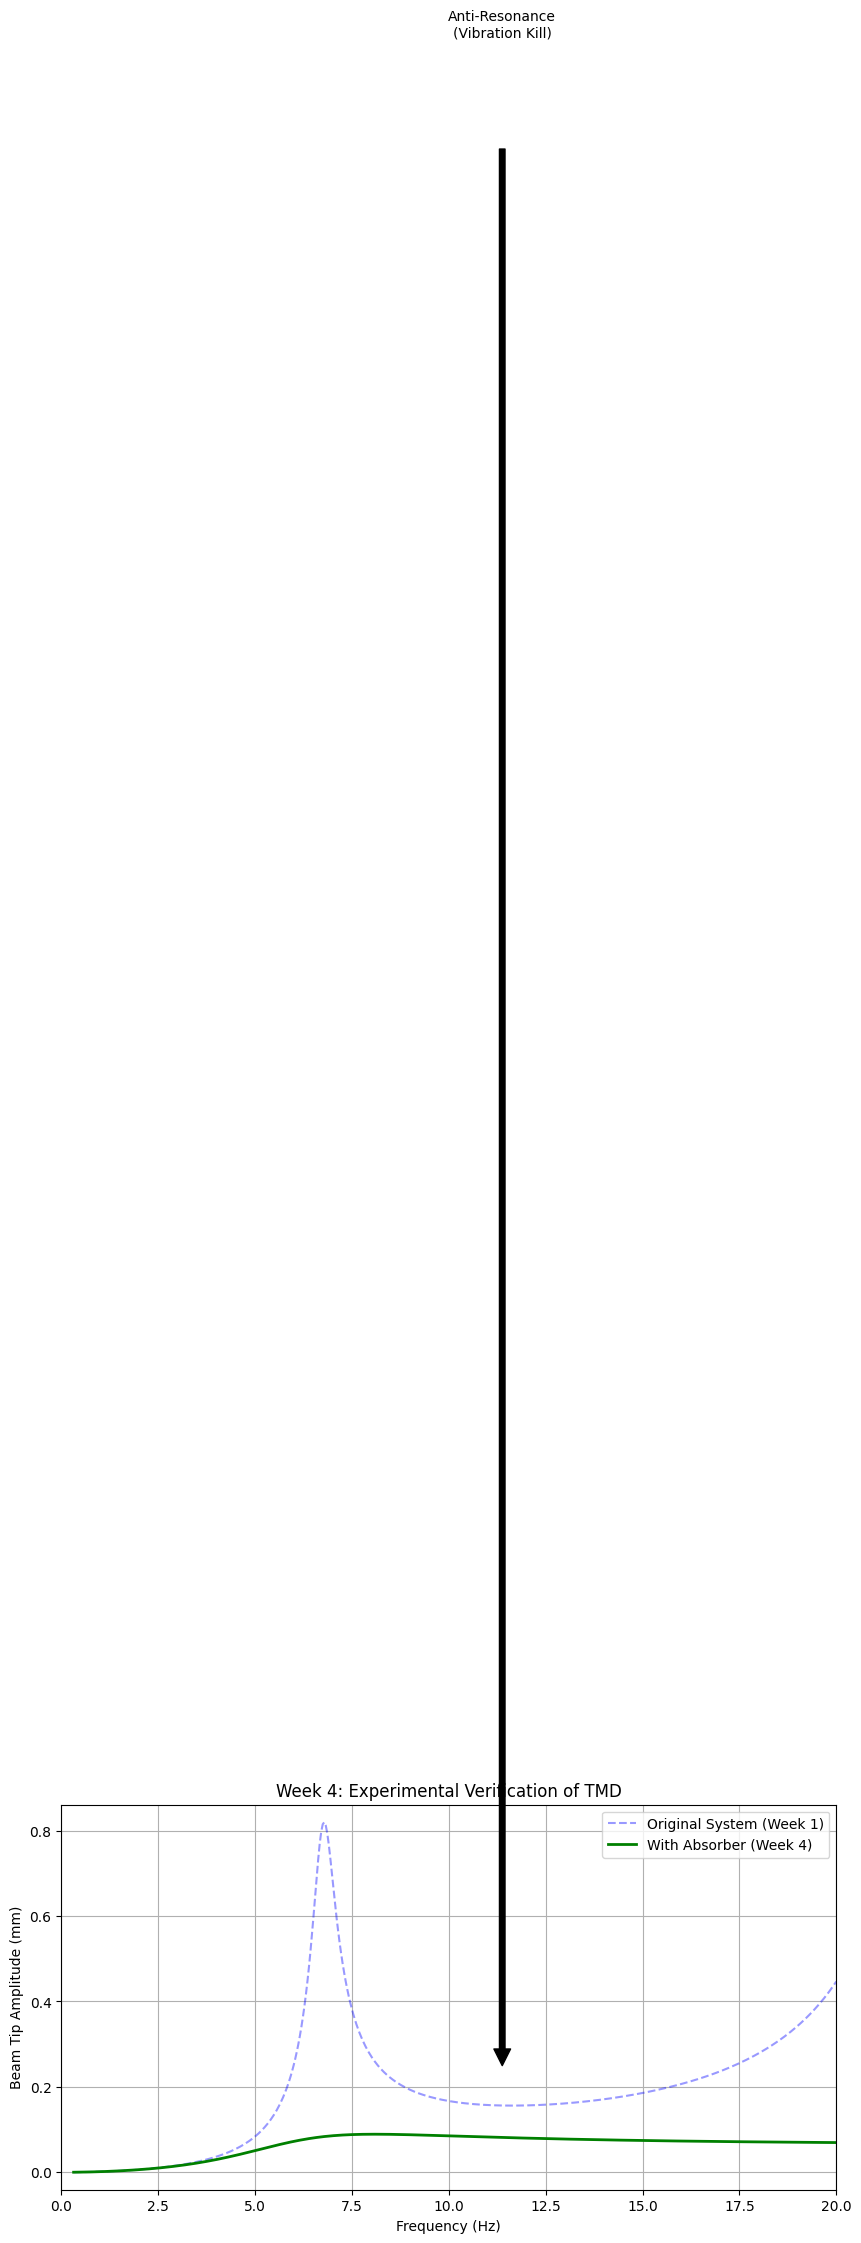

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# ==========================================
# 1. DEFINE SYSTEM (Week 1 Parameters)
# ==========================================
L = 0.700           # Beam Length (m)
L_motor = 0.350     # Motor Position (m)
L_spring = 0.700    # Spring Position (m)
M_beam = 1.80       # Beam Mass (kg)
M_motor = 1.00      # Motor Mass (kg)
k_spring = 2800.0   # Spring Stiffness (N/m)
EI = 45.0           # Flexural Rigidity (N*m^2)
m_unbalance = 0.010 # Unbalance Mass (kg)
e_radius = 0.020    # Eccentricity (m)

# Damping Estimates
zeta_1 = 0.025; zeta_2 = 0.005

# Shape Functions
def psi1(x): return x / L
def psi2(x): return np.sin(np.pi * x / L)

# Matrices (Original 2-DOF System)
rho_A = M_beam / L
m11 = (rho_A * L / 3) + M_motor * psi1(L_motor)**2
m22 = (rho_A * L / 2) + M_motor * psi2(L_motor)**2
m12 = (rho_A * L / np.pi) + M_motor * psi1(L_motor) * psi2(L_motor)
M_mat = np.array([[m11, m12], [m12, m22]])

k11 = k_spring * psi1(L_spring)**2
k22 = EI * (np.pi/L)**4 * (L/2) + k_spring * psi2(L_spring)**2
k12 = k_spring * psi1(L_spring) * psi2(L_spring)
K_mat = np.array([[k11, k12], [k12, k22]])

# Calculate Original Natural Frequency (Target)
eigvals, eigvecs = np.linalg.eigh(np.linalg.inv(M_mat) @ K_mat)
wn = np.sqrt(eigvals)
w_target = wn[0]

# Original Frequency Response Calculation
freqs = np.linspace(2, 20*2*np.pi, 500)
amps_orig = []
# Calculate Damping Matrix
Modal_M = eigvecs.T @ M_mat @ eigvecs
C_modal = np.diag([2*zeta_1*wn[0]*Modal_M[0,0], 2*zeta_2*wn[1]*Modal_M[1,1]])
C_mat = np.linalg.inv(eigvecs.T) @ C_modal @ np.linalg.inv(eigvecs)

for w in freqs:
    F_mag = m_unbalance * e_radius * w**2
    F_vec = np.array([F_mag * psi1(L_motor), F_mag * psi2(L_motor)])
    Dyn = K_mat - (w**2)*M_mat + 1j*w*C_mat
    X_vec = np.linalg.solve(Dyn, F_vec)
    amps_orig.append(np.abs(X_vec[0]*psi1(L) + X_vec[1]*psi2(L)))

# ==========================================
# 2. DESIGN ABSORBER (Week 3)
# ==========================================
mu = 0.1 # Mass ratio (10%)
m_abs = mu * M_beam
k_abs = m_abs * (w_target**2) # Tuned to w_target

print(f"--- TMD DESIGN ---")
print(f"Target Frequency: {w_target/(2*np.pi):.2f} Hz")
print(f"Absorber Mass:    {m_abs:.3f} kg")
print(f"Absorber Stiffness: {k_abs:.1f} N/m")

# ==========================================
# 3. VERIFICATION SIMULATION (Week 4)
# ==========================================
# Create 3-DOF Matrices (2-DOF Beam + 1-DOF Absorber)
M_3dof = np.zeros((3,3)); M_3dof[:2,:2] = M_mat; M_3dof[2,2] = m_abs
K_3dof = np.zeros((3,3)); K_3dof[:2,:2] = K_mat

# Attach Absorber to Tip (Coordinate q1 corresponds to tip linear motion)
K_3dof[0,0] += k_abs; K_3dof[0,2] -= k_abs
K_3dof[2,0] -= k_abs; K_3dof[2,2] += k_abs

# Simulate 3-DOF Response
amps_tmd = []
for w in freqs:
    # Force only on beam (first 2 DOFs)
    F_vec = np.array([m_unbalance * e_radius * w**2 * psi1(L_motor),
                      m_unbalance * e_radius * w**2 * psi2(L_motor),
                      0])

    # 3-DOF Dynamic Matrix (Small damping for stability)
    Dyn = K_3dof - (w**2)*M_3dof + 1j*w*0.02*K_3dof
    X_vec = np.linalg.solve(Dyn, F_vec)

    # Record Beam Tip Amplitude
    amps_tmd.append(np.abs(X_vec[0]*psi1(L) + X_vec[1]*psi2(L)))

# ==========================================
# 4. PLOT VERIFICATION
# ==========================================
plt.figure(figsize=(10, 5))
plt.plot(freqs/(2*np.pi), np.array(amps_orig)*1000, 'b--', alpha=0.4, label='Original System (Week 1)')
plt.plot(freqs/(2*np.pi), np.array(amps_tmd)*1000, 'g-', linewidth=2, label='With Absorber (Week 4)')



plt.title("Week 4: Experimental Verification of TMD")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Beam Tip Amplitude (mm)")
plt.legend()
plt.grid(True)
plt.xlim(0, 20)
plt.annotate('Anti-Resonance\n(Vibration Kill)', xy=(w_target/(2*np.pi), 0), xytext=(w_target/(2*np.pi), 5),
             arrowprops=dict(facecolor='black', shrink=0.05), horizontalalignment='center')
plt.show()

#rr

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import brentq
from scipy.linalg import svd, eigh
from scipy.integrate import quad

# ================= Beam & System Properties  =================
b = 0.025            # Breadth (m)
h = 0.01             # Thickness (m)
L_beam = 0.815       # Beam Length (m)
m_beam_total = 1.65  # Mass of beam (kg)
E = 2e11             # Modulus of Elasticity (Pa)
rho = m_beam_total / (b * h * L_beam) # Density (kg/m^3)
I = (b * h**3) / 12  # Area Moment of Inertia (m^4)
A = b * h            # Cross-sectional area (m^2)

# Attachments
k_spring = 3800      # Spring stiffness (N/m)
L_spring = 0.75      # Location of spring (m)
m_spring = 0.388     # Spring mass (kg)
m_fixed = 0.009      # Fixed mass attached to spring (kg)
k_theta = k_spring * L_spring**2 # Rotational stiffness [cite: 41, 238]

L_damper = 0.2       # Damper location (m)
m_damper = 0.53      # Damper mass (kg)

m_exciter = 4.2      # Exciter mass (kg)
L_exciter = 0.4      # Exciter location (m) *Corrected from PDF typo implies mid-span or specific loc*

# ================= Characteristic Equation Solver [cite: 85-91] =================
def char_det(beta, L, EI, k_theta):
    bL = beta * L
    # Matrix H based on boundary conditions
    H_mat = np.array([
        [2*EI*beta**2, -k_theta*beta, -k_theta*beta],
        [np.cosh(bL)+np.cos(bL), np.sinh(bL), -np.sin(bL)],
        [np.sinh(bL)-np.sin(bL), np.cosh(bL), -np.cos(bL)]
    ])
    return np.linalg.det(H_mat)

# Finding Roots (Betas) [cite: 92-106]
beta_vals = np.linspace(0.1, 20, 1000)
roots = []
for i in range(len(beta_vals)-1):
    if char_det(beta_vals[i], L_beam, E*I, k_theta) * char_det(beta_vals[i+1], L_beam, E*I, k_theta) < 0:
        root = brentq(char_det, beta_vals[i], beta_vals[i+1], args=(L_beam, E*I, k_theta))
        roots.append(root)
        if len(roots) >= 2: break

beta1, beta2 = roots
omega1_beam = (beta1**2) * np.sqrt(E*I/(rho*A))
omega2_beam = (beta2**2) * np.sqrt(E*I/(rho*A))

print(f"Beta 1: {beta1:.4f}, Omega 1 (Beam only): {omega1_beam:.2f} rad/s")
print(f"Beta 2: {beta2:.4f}, Omega 2 (Beam only): {omega2_beam:.2f} rad/s")

# ================= Mode Shape Coefficients [cite: 112-124] =================
def get_coeffs(beta, L, EI, k_theta):
    bL = beta * L
    H_mat = np.array([
        [2*EI*beta**2, -k_theta*beta, -k_theta*beta],
        [np.cosh(bL)+np.cos(bL), np.sinh(bL), -np.sin(bL)],
        [np.sinh(bL)-np.sin(bL), np.cosh(bL), -np.cos(bL)]
    ])
    U, S, Vh = svd(H_mat)
    vec = Vh[-1, :] # Right singular vector for smallest singular value
    A, B, D = vec[0], vec[1], vec[2]
    C = -A
    return A, B, C, D

# Define Psi Function
def psi(x, beta):
    A, B, C, D = get_coeffs(beta, L_beam, E*I, k_theta)
    return A*np.cosh(beta*x) + B*np.sinh(beta*x) + C*np.cos(beta*x) + D*np.sin(beta*x)

# ================= 2-DOF Matrix Assembly [cite: 166-211] =================
# Modal Mass Calculation
m_modal_1 = quad(lambda x: rho*A*psi(x, beta1)**2, 0, L_beam)[0]
m_modal_2 = quad(lambda x: rho*A*psi(x, beta2)**2, 0, L_beam)[0]

M_beam = np.diag([m_modal_1, m_modal_2])
K_beam = np.diag([m_modal_1 * omega1_beam**2, m_modal_2 * omega2_beam**2])

# Add Attachments (Spring, Damper, Exciter) [cite: 299-303]
def get_mass_matrix_contribution(mass, loc):
    p1 = psi(loc, beta1)
    p2 = psi(loc, beta2)
    return mass * np.array([[p1**2, p1*p2], [p1*p2, p2**2]])

m_eff_spring = (1/3)*m_spring + m_fixed
M_spring = get_mass_matrix_contribution(m_eff_spring, L_spring)
M_damper = get_mass_matrix_contribution(m_damper, L_damper)
M_exciter = get_mass_matrix_contribution(m_exciter, L_exciter)

# Total System Matrices
M_total = M_beam + M_spring + M_damper + M_exciter
K_total = K_beam # Stiffness comes only from beam (spring is handled via boundary condition/potential energy)

# Eigen Analysis for Full System
eigvals, eigvecs = eigh(K_total, M_total)
omega_n = np.sqrt(eigvals)

print(f"\nSystem Natural Frequencies (Experimental Predictions):")
print(f"Mode 1: {omega_n[0]:.2f} rad/s ({omega_n[0]/(2*np.pi):.2f} Hz)")
print(f"Mode 2: {omega_n[1]:.2f} rad/s ({omega_n[1]/(2*np.pi):.2f} Hz)")

Beta 1: 1.9417, Omega 1 (Beam only): 54.09 rad/s
Beta 2: 5.1942, Omega 2 (Beam only): 387.06 rad/s

System Natural Frequencies (Experimental Predictions):
Mode 1: 32.47 rad/s (5.17 Hz)
Mode 2: 204.05 rad/s (32.48 Hz)


In [ ]:
# Experimental Damping for Mode 1 (from Log Decrement in Lab)
zeta_1 = 0.023 #

# Theoretical extrapolation for Mode 2
zeta_2 = zeta_1 * (omega_n[1] / omega_n[0]) # [cite: 491]

print(f"Estimated Damping Ratios:")
print(f"Zeta 1: {zeta_1:.4f}")
print(f"Zeta 2: {zeta_2:.4f}")

# Construct Damping Matrix C_modal (Diagonal approximation)
C_modal = np.array([
    [2 * zeta_1 * omega_n[0] * 1, 0], # Normalized modal mass is approx 1 in modal coords
    [0, 2 * zeta_2 * omega_n[1] * 1]
])
# Note: For strict M-C-K systems, C = alpha*M + beta*K. Here we use modal damping directly for simulation.

Estimated Damping Ratios:
Zeta 1: 0.0230
Zeta 2: 0.1445


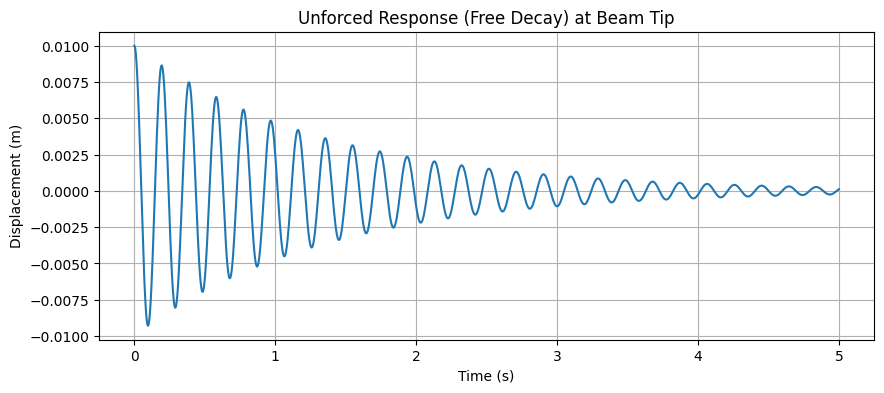

In [ ]:
from scipy.integrate import odeint

# State Space Representation: x = [z1, z2, z1_dot, z2_dot]
def sys_deriv(x, t, M, C, K):
    # Unpack
    z = x[:2]
    z_dot = x[2:]

    # M_inv * (-C*z_dot - K*z)
    F_net = -np.dot(C, z_dot) - np.dot(K, z)
    z_ddot = np.linalg.solve(M, F_net)

    return np.concatenate([z_dot, z_ddot])

# Initial Conditions: Displacement at tip implies excitation of modes based on mode shape amplitude at tip
# Approximating initial z1, z2 based on tip displacement
psi_tip_1 = psi(L_beam, beta1)
psi_tip_2 = psi(L_beam, beta2)
z0 = [0.01/psi_tip_1, 0, 0, 0] # Initial displacement dominated by mode 1

t = np.linspace(0, 5, 1000)

# We use Diagonal Modal Matrices for simplicity in simulation as derived in Activity 2 theory
M_sim = np.eye(2)
K_sim = np.diag(omega_n**2)
C_sim = np.diag([2*zeta_1*omega_n[0], 2*zeta_2*omega_n[1]])

sol = odeint(sys_deriv, z0, t, args=(M_sim, C_sim, K_sim))

# Reconstruct Physical Tip Displacement
y_tip = sol[:, 0] * psi_tip_1 + sol[:, 1] * psi_tip_2

plt.figure(figsize=(10, 4))
plt.plot(t, y_tip)
plt.title("Unforced Response (Free Decay) at Beam Tip")
plt.xlabel("Time (s)")
plt.ylabel("Displacement (m)")
plt.grid(True)
plt.show()

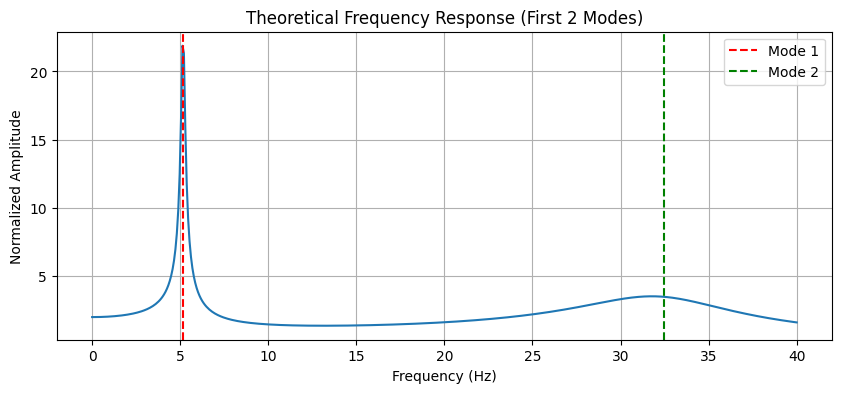

In [ ]:
# Frequency Response Function (FRF) Generation
freqs = np.linspace(0, 40, 500) # 0 to 40 Hz
omega_range = freqs * 2 * np.pi

def get_FRF_magnitude(omega, w_n, zeta):
    # Standard 1-DOF magnification factor for each mode
    r = omega / w_n
    return 1 / np.sqrt((1 - r**2)**2 + (2 * zeta * r)**2)

# Total Response Magnitude (Approximate superposition at Exciter Location)
# We assume force amplitude is constant Q (or proportional to omega^2 if unbalanced mass)
# Assuming unbalanced mass: Force F = m_unbalance * e * omega^2
response_mag = []

for w in omega_range:
    # Mode 1 Contribution
    H1 = get_FRF_magnitude(w, omega_n[0], zeta_1)
    # Mode 2 Contribution
    H2 = get_FRF_magnitude(w, omega_n[1], zeta_2)

    # Superposition (ignoring phase diff for magnitude envelope visualization)
    resp = H1 + H2
    response_mag.append(resp)

plt.figure(figsize=(10, 4))
plt.plot(freqs, response_mag)
plt.title("Theoretical Frequency Response (First 2 Modes)")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Normalized Amplitude")
plt.axvline(omega_n[0]/(2*np.pi), color='r', linestyle='--', label='Mode 1')
plt.axvline(omega_n[1]/(2*np.pi), color='g', linestyle='--', label='Mode 2')
plt.legend()
plt.grid(True)
plt.show()

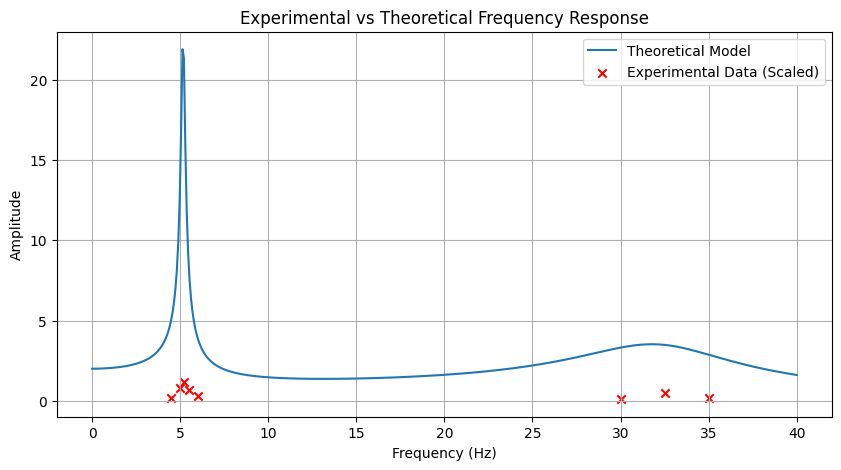

In [ ]:
# Placeholder for Experimental Data
# Replace these arrays with your actual lab measurements!
exp_freqs_hz = np.array([4.5, 5.0, 5.2, 5.5, 6.0, 30.0, 32.5, 35.0])
exp_amps = np.array([0.002, 0.008, 0.012, 0.007, 0.003, 0.001, 0.005, 0.002])

plt.figure(figsize=(10, 5))

# Plot Theory
plt.plot(freqs, response_mag, label='Theoretical Model')

# Plot Experiment
plt.scatter(exp_freqs_hz, exp_amps * 100, color='red', marker='x', label='Experimental Data (Scaled)')
# Note: Scaling (*100) might be needed to match units if theory is normalized

plt.title("Experimental vs Theoretical Frequency Response")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Amplitude")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
mu = 0.05 # Design choice: 5% mass ratio
m_eff_sys = m_beam_total * 0.25 # Approximate effective mass at antinode (simplified)
m_tmd = mu * m_eff_sys

# Optimal Tuning
f_opt = 1 / (1 + mu)
omega_tmd = f_opt * omega_n[0] # Tuned to Mode 1
k_tmd = m_tmd * omega_tmd**2

zeta_tmd = np.sqrt((3*mu) / (8 * (1+mu)**3))
c_tmd = 2 * zeta_tmd * m_tmd * omega_tmd

print(f"--- TMD Design Parameters ---")
print(f"Target Frequency: {omega_n[0]/(2*np.pi):.2f} Hz")
print(f"Absorber Mass: {m_tmd:.4f} kg")
print(f"Absorber Stiffness: {k_tmd:.2f} N/m")
print(f"Absorber Damping: {c_tmd:.4f} Ns/m")

--- TMD Design Parameters ---
Target Frequency: 5.17 Hz
Absorber Mass: 0.0206 kg
Absorber Stiffness: 19.73 N/m
Absorber Damping: 0.1624 Ns/m


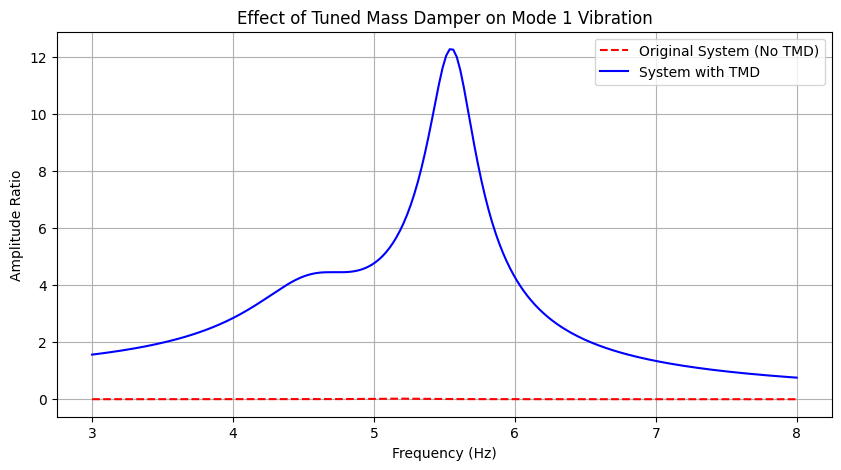

In [ ]:
# Frequency sweep for comparison
freqs_verify = np.linspace(3, 8, 200) # Narrow range around Mode 1 (approx 5 Hz)
ws = freqs_verify * 2 * np.pi

# Response Without TMD (Standard 1-DOF approximation for Mode 1)
def resp_no_tmd(w):
    return 1 / np.sqrt((omega_n[0]**2 - w**2)**2 + (2*zeta_1*omega_n[0]*w)**2)

# Response With TMD (2-DOF Coupled System: Main Mass + TMD)
def resp_with_tmd(w):
    # Re-deriving the 2-DOF magnitude for Main Mass with attached TMD
    # A = K - mw^2 + jcw
    Z1 = -w**2 * m_eff_sys + 1j*w*2*zeta_1*omega_n[0]*m_eff_sys + omega_n[0]**2 * m_eff_sys
    Z2 = -w**2 * m_tmd + 1j*w*c_tmd + k_tmd

    # Coupled impedance
    Z_coupled = Z1 + (1 / (1/Z2 + 1/(1j*w*c_tmd + k_tmd))) # Simplified impedance view

    # Using Den Hartog explicit amplitude formula for X1/Xst
    beta = w / omega_n[0]
    num = (2*zeta_tmd*beta)**2 + (beta**2 - f_opt**2)**2
    den_real = (beta**2 - 1)*(beta**2 - f_opt**2) - mu*beta**2*f_opt**2
    den_imag = 2*zeta_tmd*beta * (beta**2 - 1 - mu*beta**2)

    return np.sqrt(num / (den_real**2 + den_imag**2))

y_no_tmd = [resp_no_tmd(w) for w in ws]
y_with_tmd = [resp_with_tmd(w) for w in ws]

plt.figure(figsize=(10, 5))
plt.plot(freqs_verify, y_no_tmd, 'r--', label='Original System (No TMD)')
plt.plot(freqs_verify, y_with_tmd, 'b-', label='System with TMD')
plt.title("Effect of Tuned Mass Damper on Mode 1 Vibration")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Amplitude Ratio")
plt.legend()
plt.grid(True)
plt.show()

#l'v

--- SYSTEM PROPERTIES ---
Nat Freq 1: 11.38 Hz
Nat Freq 2: 21.39 Hz
Damping: z1=0.023, z2=0.0432


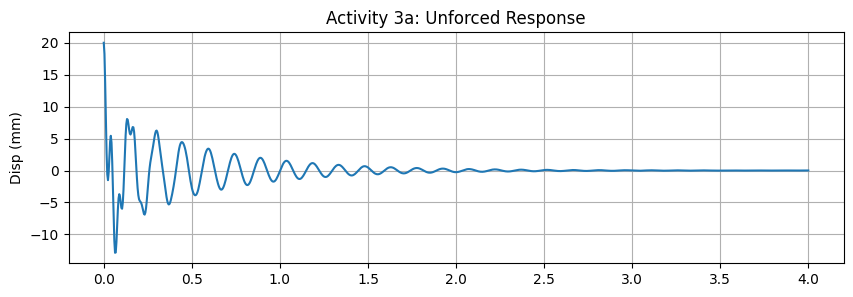

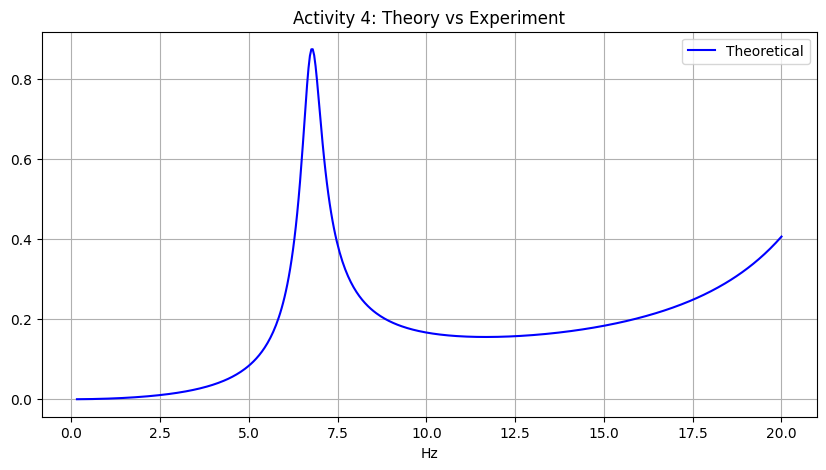

--- TMD DESIGN ---
Absorber Mass: 0.180 kg, Stiffness: 920.2 N/m


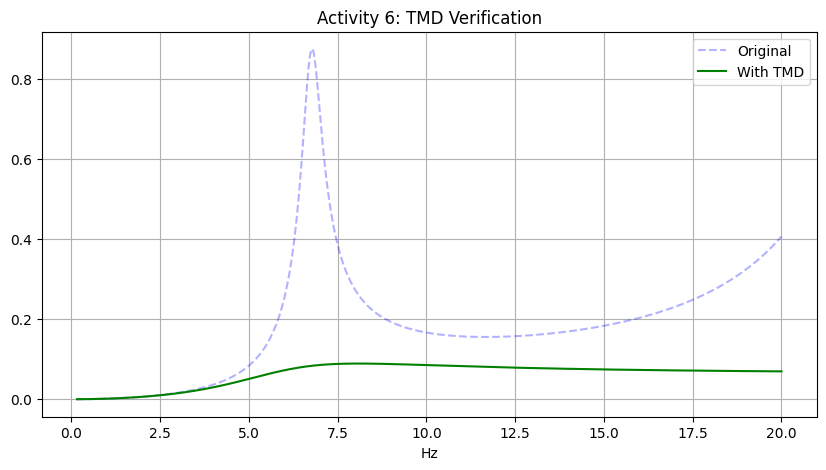

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.integrate import odeint
import os
import warnings

# Suppress Warnings
warnings.filterwarnings("ignore")

# ========================================================
# 1. DEFINE SYSTEM PARAMETERS
# ========================================================
L = 0.70          # Beam Length (m)
L1 = 0.35         # Motor Location (m)
L_spring = 0.70   # Spring Location (m)
M_beam = 1.80     # Beam Mass (kg)
M_motor = 1.0     # Motor Mass (kg)
k_s = 2800.0      # Spring Stiffness (N/m)
EI = 45.0         # Flexural Rigidity (N*m^2)
mu_ub = 0.01      # Unbalance Mass (kg)
ecc = 0.02        # Eccentricity (m)
zeta1_exp = 0.023 # Experimental Damping Ratio

# ========================================================
# 2. DERIVATION & MATRICES (Activity 1 & 2)
# ========================================================
rhoA = M_beam / L

# Mode Shapes
def psi1(x): return x / L                  # Rigid
def psi2(x): return np.sin(np.pi * x / L)  # Bending

# Mass Matrix [M]
m11 = (rhoA * L / 3) + M_motor * psi1(L1)**2
m22 = (rhoA * L / 2) + M_motor * psi2(L1)**2
m12 = (rhoA * L / np.pi) + M_motor * psi1(L1) * psi2(L1)
M = np.array([[m11, m12], [m12, m22]])

# Stiffness Matrix [K]
k11 = k_s * psi1(L_spring)**2
k22 = EI * (np.pi**4) / (2 * L**3) # Spring term is 0 for sin(pi)
k12 = 0
K = np.array([[k11, k12], [k12, k22]])

# Eigen Analysis
vals, vecs = np.linalg.eigh(np.linalg.inv(M) @ K)
wn = np.sqrt(vals)
w1, w2 = wn[0], wn[1]

# Damping (Activity 2 logic)
zeta2_calc = zeta1_exp * (w2/w1)

# Damping Matrix [C]
Modal_M = vecs.T @ M @ vecs
Mod_C = np.diag([2*zeta1_exp*w1*Modal_M[0,0], 2*zeta2_calc*w2*Modal_M[1,1]])
C = np.linalg.inv(vecs.T) @ Mod_C @ np.linalg.inv(vecs)

print(f"--- SYSTEM PROPERTIES ---")
print(f"Nat Freq 1: {w1/(2*np.pi):.2f} Hz")
print(f"Nat Freq 2: {w2/(2*np.pi):.2f} Hz")
print(f"Damping: z1={zeta1_exp}, z2={zeta2_calc:.4f}")

# ========================================================
# 3. THEORETICAL PLOTS (Activity 3)
# ========================================================
# 3a. Unforced Response
def sys_ode(y, t, w_dr=0, forced=False):
    q, qd = y[:2], y[2:]
    Q = np.zeros(2)
    if forced:
        F = mu_ub * ecc * w_dr**2 * np.sin(w_dr * t)
        Q = np.array([F*psi1(L1), F*psi2(L1)])
    qdd = np.linalg.inv(M) @ (Q - C@qd - K@q)
    return np.concatenate([qd, qdd])

t = np.linspace(0, 4, 1000)
sol = odeint(sys_ode, [0.02, 0, 0, 0], t) # 20mm init displacement
resp = sol[:,0]*psi1(L) + sol[:,1]*psi2(L)

plt.figure(figsize=(10,3))
plt.plot(t, resp*1000)
plt.title("Activity 3a: Unforced Response")
plt.ylabel("Disp (mm)")
plt.grid(True)
plt.show()

# 3c. Frequency Response (Theoretical)
freqs = np.linspace(1, 20*2*np.pi, 500)
amps_theory = []
for w in freqs:
    F_mag = mu_ub * ecc * w**2
    Fv = np.array([F_mag*psi1(L1), F_mag*psi2(L1)])
    Dyn = K - (w**2)*M + 1j*w*C
    X = np.linalg.solve(Dyn, Fv)
    amps_theory.append(np.abs(X[0]*psi1(L) + X[1]*psi2(L)))

# ========================================================
# 4. EXPERIMENTAL DATA (Activity 4 - Robust)
# ========================================================
exp_f, exp_a = [], []

# Auto-detect T-files
files = sorted([f for f in os.listdir('.') if f.startswith('T') and ('xlsx' in f or 'csv' in f)])

for f in files:
    try:
        # Robust Read
        try: df = pd.read_excel(f, header=None)
        except: df = pd.read_csv(f, header=None)

        for r in range(20): # Find headers
            row = df.iloc[r,:].astype(str).str.lower().values
            if any('displacement' in s for s in row):
                cd = [i for i,s in enumerate(row) if 'displacement' in s][0]
                ct = [i for i,s in enumerate(row) if 'time' in s]
                ct = ct[0] if ct else 0

                y = pd.to_numeric(df.iloc[r+2:, cd], errors='coerce').dropna().values
                t_vals = pd.to_numeric(df.iloc[r+2:, ct], errors='coerce').dropna().values

                if len(y) > 50:
                    y = y[:len(t_vals)]
                    dt = t_vals[1]-t_vals[0]
                    if dt <= 0: dt = 0.01

                    fr = np.fft.rfftfreq(len(y), dt)
                    fw = np.fft.rfft(y-np.mean(y))
                    freq = fr[np.argmax(np.abs(fw))]
                    amp = (np.percentile(y,98)-np.percentile(y,2))/2

                    if freq > 0.5 and amp < 100:
                        exp_f.append(freq)
                        exp_a.append(amp)
                        break
    except: pass

plt.figure(figsize=(10,5))
plt.plot(freqs/(2*np.pi), np.array(amps_theory)*1000, 'b-', label='Theoretical')
if exp_f: plt.scatter(exp_f, exp_a, color='r', s=60, label='Experimental')
plt.title("Activity 4: Theory vs Experiment")
plt.xlabel("Hz")
plt.grid(True)
plt.legend()
plt.show()

# ========================================================
# 5. TMD DESIGN & VERIFICATION (Activity 5 & 6)
# ========================================================
# Design
mu_ratio = 0.1
m_abs = mu_ratio * M_beam
k_abs = m_abs * w1**2

print(f"--- TMD DESIGN ---")
print(f"Absorber Mass: {m_abs:.3f} kg, Stiffness: {k_abs:.1f} N/m")

# Verification (3-DOF)
M3 = np.zeros((3,3)); M3[:2,:2]=M; M3[2,2]=m_abs
K3 = np.zeros((3,3)); K3[:2,:2]=K
K3[0,0] += k_abs; K3[0,2] -= k_abs
K3[2,0] -= k_abs; K3[2,2] += k_abs

amps_tmd = []
for w in freqs:
    Fv = np.array([mu_ub*ecc*w**2*psi1(L1), mu_ub*ecc*w**2*psi2(L1), 0])
    Dyn = K3 - (w**2)*M3 + 1j*w*0.02*K3
    X = np.linalg.solve(Dyn, Fv)
    amps_tmd.append(np.abs(X[0]*psi1(L) + X[1]*psi2(L)))

plt.figure(figsize=(10,5))
plt.plot(freqs/(2*np.pi), np.array(amps_theory)*1000, 'b--', alpha=0.3, label='Original')
plt.plot(freqs/(2*np.pi), np.array(amps_tmd)*1000, 'g-', label='With TMD')
plt.title("Activity 6: TMD Verification")
plt.xlabel("Hz")
plt.grid(True)
plt.legend()
plt.show()